Rev. 2021/10/08

# Program `Packaging`

Until now, the following steps have been carried out on the measurements made by the station:
1. Load of the data in the time domain, generation of measurement intervals of 10 s and elimination of those with saturations, obtaining the spectrum in amplitude for intervals of 10 min. Three files are generated:
    i) a file with the amplitude spectra for each 10 min interval for each month and sensor.
    ii) a file with the saturation percentage of each 10 min interval.
    iii) a file with information on each saturation event.
2. Filtering of the anthropogenic noise. A file similar to i) of the previous step is generated.
3. Lorentzian fitting of each spectrum. The following files are generated:
    i) a file with 14 fitting parameters for each 10 min interval.
    ii) a file with the estimated error in the Lorentzian fit of 11 parameters for each 10 min interval.
    iii) a file with the mean square error between the fitted spectra and date spectra for each 10 min interval.

In this final part of the process, a file is generated in numpy format with all the information for each month. It would be the file that could be shared between ELF stations, containing all the information necessary for the study of SRs each month and sensor.

## Readings and constant values

In [1]:
# If you execute this code the output file
# will be overwrited

pathg="S_N_DF/"         # Input path
pathdatos='S_N_Data/'   # Input path
pathgP="S_N_npz/"  # Output path

import numpy as np
import os
import datetime
def pofre(f,f0,df):
    return int(round((f-f0)/df))

We define the input and output paths. For the latter, a directory is defined where all the files for each month and sensor and for the different years  are stored (without creating a directory for each year).

In addition to the `numpy` package, the packages `os`, to access the system files, and `datetime`, to assign a temporary signal at each 10 min interval, are imported.

It is also defined, as in previous steps, the `pofre` function to determine the position of a frequency in a given interval.

In [2]:
mes='1412'
sensor=0
divi=6
fajus_inf=6.35  # Defines the lower limit of the fitting band
fajus_sup=23.75 # Defines the upper limit of the adjustment band
fcal_inf=6.
fcal_sup= 25.
fre1= 10.0
fre2= 17.0
nventa=2**13
fm=256
nintervdia=divi*24
df=float(fm)/float(nventa)
nreso=3
npar=4*nreso+2  
fajus_inf_pos= pofre(fajus_inf,fcal_inf,df)
fajus_sup_pos= pofre(fajus_sup,fcal_inf,df)
fre= np.arange(fcal_inf,fcal_sup+df,df)
freajus=fre[fajus_inf_pos:fajus_sup_pos+1]
nfajus=len(freajus)
fre1p=pofre(fre1,fajus_inf,df)
fre2p=pofre(fre2,fajus_inf,df)

We define the constants of the process in a similar way to the previous steps, including the calibration and the fitting frequency bands. Now two new frequencies are included, `fre1` and` fre2`. They define the upper frequency limits for the first and second modes (which in turn are the lower limits for the second and third modes) that are used to find the maximum amplitude of each mode in the fitted spectrum.

## Functions `lorentF` and `maxrela`

In [3]:
def lorentF(x,par):            
    val=np.zeros(nreso+1,dtype=float)
    for i in np.arange(nreso):
        val[i]=par[i]/(((x-par[nreso+i])/par[nreso*2+i])**2+1)
        val[nreso]=par[nreso*3]*x+par[nreso*3+1]
    return val.sum()

In this step of the process, the spectrum fitted by the Lorentzian function is calculated. This step would not be necessary because this adjusted spectrum can be obtained from the adjustment parameters, but in order to facilitate the subsequent process it has been included in the output file for each month. To do this, the Lorentzian function is defined from the fitting parameters and calculated for each frequency.

In [4]:
def maxrela(lista):
    ind=0
    x1=lista[0]
    x2=lista[1]
    for i in np.arange(2,len(lista)):
        if x1<x2 and x2>lista[i]:
            ind=i-1
        x1=lista[i-1]
        x2=lista[i]
        return ind

The function `maxrela` finds the position of a relative maximum. If there are multiple relative maxima, it would stick with the last one.

## Readings

In [16]:
anua='20'+mes[:2]
pathalmes=pathg+"20"+mes[:2]+"/"+mes+"/"
pathmes=pathalmes+"SR"+mes    
sensor=0   # There is a loop in the package
#for sensor in [0,1]:            
path_sat=pathmes+'_satper_'+str(sensor)
path_rs=pathmes+'_mediaNA_'+str(sensor)
path_parLO=pathmes+'_mediaLO_'+str(sensor)
path_parLOC=pathmes+'_mediaLOC_'+str(sensor)
path_parLOE=pathmes+'_mediaLOE_'+str(sensor)                
sat=np.genfromtxt(path_sat)
nintervmes=len(sat)
rs=np.genfromtxt(path_rs).reshape(nintervmes,-1)
rs_ajus=rs[:,fajus_inf_pos:fajus_sup_pos+1]
parLO=np.genfromtxt(path_parLO).reshape(nintervmes,-1)
parLOC=np.genfromtxt(path_parLOC)
parLOE=np.genfromtxt(path_parLOE).reshape(nintervmes,-1)


The paths for reading are defined. The following readings are done: 
* Percentage of saturation of each 10 min interval: `sat`. It is used to know the number of intervals of the month.
* Spectrum of each 10 min interval, `rs`.
* 14 parameters of the Lorentzian fitting for each interval of 10 min, `parLO`.
* Value of the chi-square function in the fitting of each 10 min interval, `parLOC`.
* Value of the error in the fitting of each parameter for each 10 min interval, `parLOE`.

## Fitted spectrum

In [17]:
rs_LO=np.zeros((nintervmes,nfajus),dtype=float)
for j in np.arange(nintervmes):
    for i in np.arange(nfajus):
        rs_LO[j,i]=lorentF(freajus[i],parLO[j,3:])  

The fitted spectrum is calculated with Lorentzian functions.

In [18]:
import matplotlib.pyplot as plt

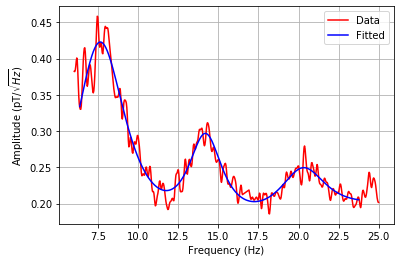

In [20]:
plt.plot(fre,rs[2000,:],c='r',label='Data')
plt.plot(freajus,rs_LO[2000,:],c='b',label='Fitted')
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'Amplitude (pT/$\sqrt{Hz}$)')
plt.legend(loc=1)
#plt.savefig('Fig_ajuste.eps')
plt.show()

## Global maximum amplitude and frequency

In [21]:
pr=np.zeros((nintervmes,nreso*2),dtype=float)
for j in np.arange(nintervmes):
    bm1= rs_LO[j,0:fre1p]
    pm1= np.argmax(bm1)
    if pm1 == 0 or pm1 == len(bm1)-1 :
        pm1=maxrela(bm1)
    bm2= rs_LO[j,fre1p:fre2p]
    pm2=np.argmax(bm2)
    if pm2 == 0 or pm2 == len(bm2)-1 :
        pm2=maxrela(bm2)
    pm2=pm2+fre1p
    bm3= rs_LO[j,fre2p:]
    pm3= np.argmax(bm3)
    if pm3 == 0 or pm3 == len(bm3)-1 :
        pm3=maxrela(bm3)
    pm3=pm3+fre2p
    pr[j]=np.array([rs_LO[j,pm1],(freajus[pm1]+freajus[pm1-1])/2+\
                df*(rs_LO[j,pm1]-rs_LO[j,pm1-1])/\
                (2*rs_LO[j,pm1]-rs_LO[j,pm1-1]-rs_LO[j,pm1+1]),\
                rs_LO[j,pm2],(freajus[pm2]+freajus[pm2-1])/2+\
                df*(rs_LO[j,pm2]-rs_LO[j,pm2-1])/\
                (2*rs_LO[j,pm2]-rs_LO[j,pm2-1]-rs_LO[j,pm2+1]),\
                rs_LO[j,pm3],(freajus[pm3]+freajus[pm3-1])/2+\
                df*(rs_LO[j,pm3]-rs_LO[j,pm3-1])/\
                (2*rs_LO[j,pm3]-rs_LO[j,pm3-1]-rs_LO[j,pm3+1])])

This part of the code calculates the local maximum amplitudes and frequencies for each mode. It has been included in this part in order to make it optional with respect to the Lorentzian adjustment made in the previous step.

The usual way to find a maximum is through the function `np.argmax(list)` (which returns the position of the maximum in `list`), which acts on each mode frequency band. But it can happen that the absolute maximum is at the ends of the band and that there is a relative maximum within it, perhaps because the spectrum has tilted so much. To find a possible relative maximum, the function `maxrela(list)` is used. If there are multiple relative maxima, it would stick with the last one.

The peak and frequency values are stored for each 10 min interval of the month in the array `pr`.

## 10 min interval temporal identification 

In [22]:
dt=3.906E+3 # microseconds
pathmesdatos=pathdatos+"20"+mes[:2]+'/'+mes+'/'
fichmesL=sorted(os.listdir(pathmesdatos))
fichmes=fichmesL.copy()
for i in fichmesL:
    if i[0]!= 's': 
        fichmes.remove(i)
nfich=len(fichmes)
nfich2=(nfich)//2
if fichmes[0][0] != 's':
    print('Warning, check the data files')
fichs0dat=fichmes[0:nfich2:2]
fichs0txt=fichmes[1:nfich2:2]
fichs1dat=fichmes[nfich2::2]
fichs1txt=fichmes[nfich2+1::2]
if sensor == 0:
    ft=fichs0txt
elif sensor ==1:
    ft=fichs1txt
else:
    print('Warning, check the sensor identification')
tiempo=[]
for fich in ft:
    f=open(pathmesdatos+fich)
    da_ho=f.readlines()[4][22:45]
    day=int(da_ho[0:2])
    month=int(da_ho[3:5])
    year=int(da_ho[6:10])
    hour=int(da_ho[11:13])
    minute=int(da_ho[14:16])
    second=int(da_ho[17:19])
    micro=int(da_ho[20:23]+'000')
    tiho=datetime.datetime(year,month,day,hour,minute,second,micro)
    for i in range(divi):
        intedi=(3600/divi*fm)*dt*i
        timu=tiho+datetime.timedelta(microseconds=intedi)
        tiempo.append(str(timu))
if(len(tiempo) != nintervmes):
    print('Warning, check the files of the month')
tiempo=np.array(tiempo, dtype=str)    

The start time of each 10 min interval has also been added to the output. The one hour station data files (in alphabetical order) for the month are assumed to be in groups of four: two of them contain the recordings and the other two contain information for each sensor. Once the sensor has been chosen, the list with the names of the information files is selected. Each file is opened and all lines are read. We select the fifth line and in that line the characters 22 to 44, which contain the date and time. Day, month, year, hour, minute, second and microsecond are defined. With this data, the function `datetime.datetime` is called. Each hour of measurement of the station has been divided into intervals, so that the beginning of each 10 min interval will have to be calculated, adding the duration from the begining time of the corresponding hour. The method `datetime.timedelta` is required to take into account the temporal divisions, since we have hours of measurements that fall in two UTM hours. Finally, the time is saved in the list, which is converted to numpy array so that it can be written with the function `np.savez` in the next step.

## Outputs

In [17]:
pa= 'SN_'+mes+'_'+str(sensor)
sal= (sat,fre,freajus,rs,rs_LO,parLO,parLOC,parLOE,pr,tiempo)
np.savez(pathgP+pa,*sal)

The output is made in a file with npz format that uses the NPY format for writing/reading data.

The list of saved arrays is:
- sat: saturation percentage of each 10 min interval of the month
- fre: list of frequencies in the calibrated band
- freajus: list of frequencies in the fitted band
- rs: spectrum obtained from the measurements
- rs_LO: spectrum obtained from the Lorentzian fitting
- ParLO: parameters obtained from the fitting (global mode amplitudes, individual mode amplitudes, amplitudes, resonant frequencies, widths, slope and intercept of the stright line)
- parLOC: chi-square function for each 10 min interval
- parLOE: error in the fitting parameters for each 10 min interval
- pr: local maximum amplitudes and frequencies (amplitude1, frequency1, amplitude2, frequency2, ...) for each mode and for each 10 min interval 
- time: date and time of the beginning of each 10 min interval.